변수

Hammer_price 낙찰값

Minimum_sales_price 최저매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 가격
(즉, 입착 시작가?)

point.x 경도

point.y 위도

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_master_train.csv')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_master_test.csv')

In [ ]:
regist = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_regist.csv')

In [ ]:
rent = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_rent.csv')

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_result.csv')

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[3]apartment/data_kr/Auction_submission.csv')

In [ ]:
train=train.loc[train['Auction_key']!=10,] ### 제거한 이유? ###

In [ ]:
corr = train.corr().Hammer_price.sort_values()
corr

Auction_key                   -0.494335
point.x                       -0.357186
Auction_count                 -0.060598
Auction_miscarriage_count     -0.059509
addr_bunji1                   -0.018607
addr_bunji2                    0.000084
road_bunji1                    0.028545
Total_land_gross_area          0.094260
road_bunji2                    0.206681
Claim_price                    0.227550
Current_floor                  0.263951
Total_floor                    0.288378
point.y                        0.357915
Total_land_real_area           0.457389
Total_land_auction_area        0.470488
Total_building_area            0.644298
Total_building_auction_area    0.651966
Total_appraisal_price          0.976729
Minimum_sales_price            0.992170
Hammer_price                   1.000000
Name: Hammer_price, dtype: float64

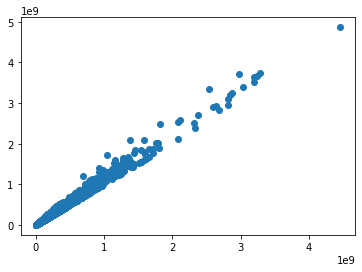

In [ ]:
plt.scatter(train.Minimum_sales_price, train.Hammer_price)

Minimum_sales_price는 target(Hammer_price)와 상관관계의 절대값이 높다.

그런데 문제는 이 변수와 target의 상관관계가 너무 높다는 것이다. 

이대로 학습을 진행하면, Minimum_sales_price의 중요도가 매우 높아셔서, 다른 featrues의 정보가 묻힐 가능성이 높다고 생각된다.

따라서 위 정보를 다른 방식으로 사용할 수 있으면 좋을 것이다.

**Hammer_price >= Minimum_sales_price 일 것이므로, Minimum_sales_price 에 대비해 몇 %(ratio) 를 예측하도록 문제를 바꾸고자 한다.**

이 방법의 또 다른 장점은 Hammer_price는 수치의 절댓값이 큰 편이라 variance가 자연스레 커진다. 하지만 **ratio는 1~2정도의 수치이므로 variance가 적기 때문에 좀더 세밀한 예측을 할 수 있게 된다.**

---

**결론**

new_target(real) = Hammer_price/Minimum_sales_price 로 잡고, 예측값에 다시 Minimum_sales_price 를 곱하여 실제 Hammer_price 를 예측하는 방식으로 문제를 재구성했다.

In [ ]:
train['real'] = train.Hammer_price / train.Minimum_sales_price
test['real'] = test.Hammer_price / test.Minimum_sales_price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


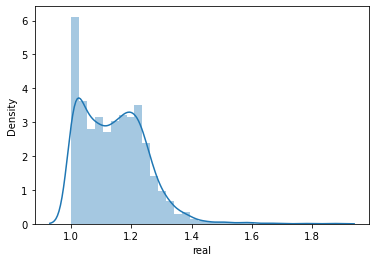

In [ ]:
sns.distplot(train['real'])

In [ ]:
train.drop(['Hammer_price'],axis=1).corr().real.sort_values()

Auction_key                   -0.062983
Current_floor                 -0.055709
Total_floor                   -0.051553
Minimum_sales_price           -0.042232
point.x                       -0.039527
road_bunji1                   -0.021469
addr_bunji2                   -0.002634
Total_land_gross_area          0.006978
addr_bunji1                    0.013455
Total_appraisal_price          0.020108
Total_building_area            0.025305
Total_building_auction_area    0.027848
point.y                        0.038295
road_bunji2                    0.047078
Total_land_real_area           0.059067
Total_land_auction_area        0.060240
Claim_price                    0.104271
Auction_count                  0.356021
Auction_miscarriage_count      0.381825
real                           1.000000
Name: real, dtype: float64

# 위도 경도 real 값

In [ ]:
cop = train.copy()
print(train['point.x'].max()-train['point.x'].min())
print(train['point.y'].max()-train['point.y'].min())
cop['x'] = pd.cut(train['point.x'],100)
cop['y'] = pd.cut(train['point.y'],100)

2.4464783999999753
2.6341893000000027


In [ ]:
cop1=cop.groupby(['x','y']).size().reset_index(name='count')
cop1['count'].value_counts()

0     9839
1       15
5       12
3       10
7        8
2        8
4        8
8        8
11       7
13       7
14       6
23       5
20       5
10       5
9        5
16       5
15       4
12       4
6        4
22       4
18       4
27       3
19       3
30       3
17       3
25       2
31       2
26       2
21       2
41       1
28       1
29       1
24       1
45       1
38       1
35       1
Name: count, dtype: int64

In [ ]:
cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
cop2.real.isna().sum() ### NaN값이 너무 많이 발생한다.###

9839

In [ ]:
cop=pd.merge(cop1,cop2,on=['x','y'],how='left')
print(cop)
cop=cop.loc[cop['count']>=9]

                       x                 y  count  real
0     (126.807, 126.834]  (35.049, 35.078]      0   NaN
1     (126.807, 126.834]  (35.078, 35.104]      0   NaN
2     (126.807, 126.834]   (35.104, 35.13]      0   NaN
3     (126.807, 126.834]   (35.13, 35.157]      0   NaN
4     (126.807, 126.834]  (35.157, 35.183]      0   NaN
...                  ...               ...    ...   ...
9995  (129.231, 129.256]   (37.554, 37.58]      0   NaN
9996  (129.231, 129.256]   (37.58, 37.607]      0   NaN
9997  (129.231, 129.256]  (37.607, 37.633]      0   NaN
9998  (129.231, 129.256]  (37.633, 37.659]      0   NaN
9999  (129.231, 129.256]  (37.659, 37.686]      0   NaN

[10000 rows x 4 columns]


In [ ]:
cop=cop.loc[cop['count']>=9]

In [ ]:
print(cop.real.isna().sum())
cop

0


,x,y,count,real
95,"(126.807, 126.834]","(37.554, 37.58]",11,1.106657
193,"(126.834, 126.858]","(37.501, 37.528]",22,1.138617
194,"(126.834, 126.858]","(37.528, 37.554]",23,1.138008
195,"(126.834, 126.858]","(37.554, 37.58]",12,1.149220
292,"(126.858, 126.883]","(37.475, 37.501]",11,1.136653
...,...,...,...,...
9404,"(129.109, 129.134]","(35.157, 35.183]",25,1.170872
9405,"(129.109, 129.134]","(35.183, 35.209]",30,1.180296
9503,"(129.134, 129.158]","(35.13, 35.157]",10,1.085319
9604,"(129.158, 129.182]","(35.157, 35.183]",22,1.125366


In [ ]:
area = cop.pivot("y", "x", "real") # y: index, x:columns, real:values
area # 위도 / 경도에 따른 가격 변화

x,"(126.807, 126.834]","(126.834, 126.858]","(126.858, 126.883]","(126.883, 126.907]","(126.907, 126.932]","(126.932, 126.956]","(126.956, 126.981]","(126.981, 127.005]","(127.005, 127.03]","(127.03, 127.054]","(127.054, 127.079]","(127.079, 127.103]","(127.103, 127.127]","(127.127, 127.152]","(128.889, 128.913]","(128.962, 128.987]","(128.987, 129.011]","(129.011, 129.036]","(129.036, 129.06]","(129.06, 129.085]","(129.085, 129.109]","(129.109, 129.134]","(129.134, 129.158]","(129.158, 129.182]"
y,,,,,,,,,,,,,,,,,,,,,,,,
"(37.554, 37.58]",1.106657,1.149220,NaN,NaN,1.121964,NaN,1.060731,NaN,1.144292,1.111321,1.170156,1.115361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.501, 37.528]",NaN,1.138617,1.193049,1.137292,1.098834,1.157545,1.177032,NaN,1.182147,1.138632,1.143677,1.165752,1.157270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.528, 37.554]",NaN,1.138008,1.122478,1.126222,NaN,1.148510,NaN,NaN,1.163593,1.170208,NaN,1.165143,1.183770,1.144131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.475, 37.501]",NaN,NaN,1.136653,1.199714,1.187032,1.113097,1.176441,1.150346,1.132009,1.136927,1.176548,NaN,1.127775,1.176444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.448, 37.475]",NaN,NaN,NaN,1.153982,1.130363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.58, 37.607]",NaN,NaN,NaN,1.118953,1.190174,1.148453,NaN,NaN,1.159431,1.129985,1.150099,1.113241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.607, 37.633]",NaN,NaN,NaN,NaN,1.114928,NaN,NaN,NaN,1.155724,1.166772,1.131972,1.136037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.633, 37.659]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123297,1.146984,1.142426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.659, 37.686]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.144668,1.122477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 히트맵을 그릴 때, 정수 , 정수 슬라이스만 갖을 수 있는 오류가 생긴다.

area = area.reset_index(drop=True)
area.columns = range(0,24)
area

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1.106657,1.149220,NaN,NaN,1.121964,NaN,1.060731,NaN,1.144292,1.111321,1.170156,1.115361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.138617,1.193049,1.137292,1.098834,1.157545,1.177032,NaN,1.182147,1.138632,1.143677,1.165752,1.157270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.138008,1.122478,1.126222,NaN,1.148510,NaN,NaN,1.163593,1.170208,NaN,1.165143,1.183770,1.144131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.136653,1.199714,1.187032,1.113097,1.176441,1.150346,1.132009,1.136927,1.176548,NaN,1.127775,1.176444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.153982,1.130363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.118953,1.190174,1.148453,NaN,NaN,1.159431,1.129985,1.150099,1.113241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,1.114928,NaN,NaN,NaN,1.155724,1.166772,1.131972,1.136037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123297,1.146984,1.142426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.144668,1.122477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.165154,1.149347,1.096877,1.140374,NaN,1.164583,NaN,NaN,NaN,NaN


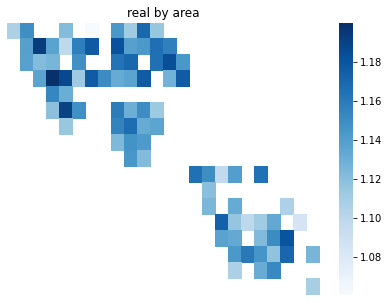

In [ ]:
plt.subplots(1, 1, figsize=(7, 5))
plt.title("real by area")
sns.heatmap(area, annot=False, xticklabels=False,yticklabels=False,cmap="Blues")
plt.show()

위도와 경도를 100개로 나누어서 각 grid 안에 real 값을 평균내서 heatmap을 그려보았다.

단, 각 grid안에 object가 9개 이상인 grid만을 뽑았다.

예상외로 지역별 real값의 차이가 있어 보인다. 범위를 많이 좁히고, 세밀하게 예측하기 위해 'addr_dong'이라는 변수를 모델이 포함시키면 좋겠다.

물론 point.x / point.y도 있지만 그걸로는 부족해 보인다.

In [ ]:
train['addr_dong'].nunique()

285

In [ ]:
len(train)

1932

addr_dong은 총 285개의 unique한 값들을 가지고 있고, 그에 비해 우리가 가지고 있는 데이터셋은 너무 적다.(1932 rows × 42 columns)

(데이터셋이 좀 더 크면 catboost같이 범주형 데이터를 잘 다루어주는 모델도 사용해보았을 것이다.)

위치적인 요소들을 고려해줄수 있는 외부데이터가 필요해보인다.

# 날짜 차이 고려

close_date과 final_auction_date, first_auction_date과 appraisal_date, final_auction_date과 first_auction_date간의 차이(날 차이)를 변수로 만들어 보았다.

close_date 종국일자

법원에서 해줄수 있는 모든 과정을 끝내는걸 종국이라고 합니다. **종국 일자라함은 배당이 끝나는 날을 종국일자라 합니다**

final_auction_date 최종경매일

first_auction_date 최초경매일

appraisal_date 감정일자

In [ ]:
# error 매개변수 
# pd.to_datetime(train['Close_date']) -> (error 발생) Out of bounds nanosecond timestamp: 1111-11-11 00:00:00

errors: error는 총 3개의 옵션이 존재합니다.

- errors = 'ignore' -> 만약 숫자로 변경할 수 없는 데이터라면 숫자로 변경하지 않고 원본 데이터를 그대로 반환합니다.

- **errors = 'coerce' -> 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환합니다.**

- errors = 'raise' -> 만약 숫자로 변경할 수 없는 데이터라면 에러를 일으키며 코드를 중단합니다.

In [ ]:
train['daydiff1']=(pd.to_datetime(train['Close_date'],errors='coerce') - pd.to_datetime(train['Final_auction_date'],errors='coerce'))#.dt.days
train['daydiff1']

0      86 days
1      56 days
2      61 days
3      55 days
4      62 days
         ...  
1928   72 days
1929   72 days
1930   70 days
1931   71 days
1932   92 days
Name: daydiff1, Length: 1932, dtype: timedelta64[ns]

In [ ]:
train['daydiff1']=(pd.to_datetime(train['Close_date'],errors='coerce') - pd.to_datetime(train['Final_auction_date'],errors='coerce')).dt.days
train['daydiff1']

0       86.0
1       56.0
2       61.0
3       55.0
4       62.0
        ... 
1928    72.0
1929    72.0
1930    70.0
1931    71.0
1932    92.0
Name: daydiff1, Length: 1932, dtype: float64

In [ ]:
train['daydiff1'].isnull().sum()

12

np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)

In [ ]:
train['daydiff1']=(pd.to_datetime(train['Close_date'],errors='coerce') - pd.to_datetime(train['Final_auction_date'],errors='coerce')).dt.days
train['daydiff1']=np.where(train['daydiff1'].isnull(),train['daydiff1'].mean(),train['daydiff1'])

train['daydiff']=(pd.to_datetime(train['First_auction_date'],errors='coerce') - pd.to_datetime(train['Appraisal_date'],errors='coerce')).dt.days
train['daydiff']=np.where(train['daydiff']<0,train['daydiff'].median(),train['daydiff'])

train['daydiff2']=(pd.to_datetime(train['Final_auction_date'],errors='coerce')-pd.to_datetime(train['First_auction_date'],errors='coerce')).dt.days

In [ ]:
test['daydiff1']=(pd.to_datetime(test['Close_date'],errors='coerce') - pd.to_datetime(test['Final_auction_date'],errors='coerce')).dt.days
test['daydiff1']=np.where(test['daydiff1'].isnull(),test['daydiff1'].mean(),test['daydiff1'])

test['daydiff']=(pd.to_datetime(test['First_auction_date'],errors='coerce') - pd.to_datetime(test['Appraisal_date'],errors='coerce')).dt.days
test['daydiff']=np.where(test['daydiff']<0,test['daydiff'].median(),test['daydiff'])

test['daydiff2']=(pd.to_datetime(test['Final_auction_date'],errors='coerce') - pd.to_datetime(test['First_auction_date'],errors='coerce')).dt.days

In [ ]:
regist # Auctiuon_regist.csv – 아파트에 대한 등기 정보

,Auction_key,Auction_seq,Regist_type,Regist_class,Regist_date,Creditor,Regist_price
0,1,10001,집합건물등기,소유이전,20050715,Private,0
1,1,10002,집합건물등기,가압,20050914,푸른이상호저축은행,860547945
2,1,10003,집합건물등기,가압,20051229,Private,189800000
3,1,10004,집합건물등기,가압,20060428,Private,1346000000
4,1,10005,집합건물등기,가처분,20070410,Private,0
...,...,...,...,...,...,...,...
20697,2762,10002,집합건물등기,가압,20160725,한국씨티은행,17393014
20698,2762,10003,집합건물등기,가압,20160829,삼성생명보험,6751324
20699,2762,10004,집합건물등기,가압,20161028,우리카드,8456049
20700,2762,10005,집합건물등기,강제,20170717,삼성생명보험,0


In [ ]:
#Regist_date을 datetime 형태로 변환
regist['Regist_date']=pd.to_datetime(regist['Regist_date'].astype('str').str.slice(0,4)+"-"+regist['Regist_date'].astype('str').str.slice(4,6)+"-"+regist['Regist_date'].astype('str').str.slice(6,8),errors='coerce')

In [ ]:
regist

,Auction_key,Auction_seq,Regist_type,Regist_class,Regist_date,Creditor,Regist_price
0,1,10001,집합건물등기,소유이전,2005-07-15,Private,0
1,1,10002,집합건물등기,가압,2005-09-14,푸른이상호저축은행,860547945
2,1,10003,집합건물등기,가압,2005-12-29,Private,189800000
3,1,10004,집합건물등기,가압,2006-04-28,Private,1346000000
4,1,10005,집합건물등기,가처분,2007-04-10,Private,0
...,...,...,...,...,...,...,...
20697,2762,10002,집합건물등기,가압,2016-07-25,한국씨티은행,17393014
20698,2762,10003,집합건물등기,가압,2016-08-29,삼성생명보험,6751324
20699,2762,10004,집합건물등기,가압,2016-10-28,우리카드,8456049
20700,2762,10005,집합건물등기,강제,2017-07-17,삼성생명보험,0


In [ ]:
#Auction_date와 Rent_date를 datetime 형태로 변환
result['Auction_date']=pd.to_datetime(result['Auction_date'])
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')

In [ ]:
#regist(등기부등본)에 써져 있는 등기 중 가장 일찍 등기된 것을 고른다 ==&gt; 가장 일찍 등기된 날짜가 건설작업완료 날짜의 추정치이다.
#built_date이라는 변수는 건설작업완료 추정 년도를, built_date1는 그 년도가 2000년을 넘기는지 아닌지를 가르키는 변수이다.
train['built_date']=train.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
train['built_date']=pd.DatetimeIndex(train['built_date']).year
train['built_date']=np.where(train['built_date'].isnull(),train['built_date'].median(),train['built_date'])

train['built_date1']=train['built_date']<=2000



test['built_date']=test.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
test['built_date']=pd.DatetimeIndex(test['built_date']).year
test['built_date']=np.where(test['built_date'].isnull(),test['built_date'].median(),test['built_date'])

test['built_date1']=test['built_date']<=2000

# 가격 정보

우리는 Hammer_price/Minimum_price를 타겟으로 놓고 모델을 training시킬 것이므로, Minimum_sales_price나 Total_appraisal_price같이 그냥 단순 금액치보다는 **비율적인 정보가 더 중요하다.**

그래서 일단 falld(Minimum_sales_price/Total_appraisal_price)라는 변수를 만든다. 

**경매가가 유찰이 진행될 수록 감정가의 80% ,64% ,51.2%,41%,32.8%, 26.2%, 21%, 16.8%, 13.4% 이런 식으로 떨어지기 때문에** lastupp, **낙찰되기 직전의 유찰된 경매에서의 Minimum_sales_price / Total_appraisal_price,이라는 변수를 생성한다**

예를 들어 감정 평가액이 10억이고 4번 유찰되어 최저경매가가 4.1억이면, falld는 4.1억/10억==0.41이 될 것이고, 낙찰되기 이전, 즉 3번 유찰되었던 시점에 최저경매가는 5.12억이므로 lastupp은 5.21/10==0.521이 될 것이다.

**upp은 lastupp/falld를 한 것이고, lastupp_p는 lastupp에서 Total_appraisal_price를 곱한 값이다.**


이렇게 단순금액보다는 비율적인 요소를 더 잘 나타낼 수 있는 변수들을 집중적으로 생성해내었고 모델의 정확도 상승에도 큰 도움을 주었다.

In [ ]:
train['falld']=(train['Minimum_sales_price']/train['Total_appraisal_price']).round(3)
train['falld'].unique()

array([0.8  , 0.64 , 1.   , 0.512, 0.41 , 0.21 , 0.328, 0.262, 0.134])

In [ ]:
train['falld']=(train['Minimum_sales_price']/train['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

train['lastupp']=train.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)


test['falld']=(test['Minimum_sales_price']/test['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

test['lastupp']=test.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)

train['upp']=train['lastupp']/train['falld']
test['upp']=test['lastupp']/test['falld']

train['lastupp_p']=train['lastupp']*train['Total_appraisal_price']
test['lastupp_p']=test['lastupp']*test['Total_appraisal_price']

Auction_miscarriage_count 총유찰횟수

In [ ]:
train['one']=(train['Auction_miscarriage_count']==0)
test['one']=(test['Auction_miscarriage_count']==0)

# 아파트 정보

아파트의 브랜드가치도 경매시장에 영향을 줄 수 있을 것이다. 우리나라 대표 아파트 브랜드 5곳(더샵, 자이, 아이파크, 래미안, 힐스테이트)을 뽑아서 addr_etc에서 이 단어의 포함유무를 통해 아파트의 브랜드 변수(apart)를 만든다. 만약 위의 5가지 중 어느 곳에도 포함되어 있지 않는다면 other로 대체한다.

In [ ]:
train.addr_etc

0                      해운대엑소디움 5층 101-502호
1               해운대두산위브더제니스 103동 51층 5103호
2                      백양그린 206동 14층 1403호
3                      대연청구 109동 11층 1102호
4                            동조리젠시 7층 703호
                       ...                
1928                     삼성 110동 15층 1501호
1929                 상계불암대림 205동 23층 2303호
1930    ,회현동2가 89 남산롯데캐슬아이리스 19층 102-1905호
1931                  삼성래미안 110동 11층 1102호
1932                   강서한강자이 106동 7층 703호
Name: addr_etc, Length: 1932, dtype: object

In [ ]:
apartname=pd.Series(["더샵","자이","아이파크","래미안","힐스테이트"])

In [ ]:
def get_apartname(string_val,apartname):
    if apartname.apply(lambda x: [x in y for y in [string_val]][0]).sum() > 0:
        return np.asscalar(apartname.loc[apartname.apply(lambda x: [x in y for y in [string_val]][0])])
    else:
        return "other"

In [ ]:
train['apart']=train.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)
test['apart']=test.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


# 은행 정보

In [ ]:
namecred=pd.Series(train['Creditor'].value_counts().head().index.tolist())
namecred

0    Private
1       국민은행
2       우리은행
3     중소기업은행
4       하나은행
dtype: object

In [ ]:
def getcred(string_val,namecred):
    if namecred.isin([string_val]).sum() > 0:
        # print(np.asscalar(namecred.loc[namecred.isin([string_val])]))
        return np.asscalar(namecred.loc[namecred.isin([string_val])])
    else:
        return "other"
        
train['cred']=train.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)
test['cred']=test.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


# 권리의 인수여부

In [ ]:
#경매에서 권리의 인수여부는 말소기준권리를 기준으로 결정된다.
#말소기준권리는 저당,압류, 가압 중에서 가장 먼저 일어난 것이며, 각각의 Auction_key마다 이것을 찾아 malsogijun이라는 데이터프레임을 만들었다.
regist['Regist_class']=regist['Regist_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_class']=rent['Rent_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')
malsogijun=regist.loc[pd.Series(regist['Regist_class']).isin(["저당","압류","가압"]),].groupby(['Auction_key'])['Regist_date'].min().reset_index()

In [ ]:
regist.loc[pd.Series(regist['Regist_class']).isin(["저당","압류","가압"]),].groupby(['Auction_key'])['Regist_date'].min().reset_index()

,Auction_key,Regist_date
0,1,2005-09-14
1,3,2005-09-14
2,5,2002-07-29
3,6,2011-03-31
4,7,2011-06-13
...,...,...
2624,2758,2015-07-23
2625,2759,2012-03-21
2626,2760,2014-02-25
2627,2761,2006-12-04


이 말소기준보다 전에 일어나고 점유하고 있는 임차인(**대항력을 가진 임차인**)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 take_over_rent라는 변수에 저장한다


In [ ]:
#이 말소기준보다 전에 일어나고 점유하고 있는 임차인(대항력을 가진 임차인)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 take_over_rent라는 변수에 저장한다
def get_rent_malso(Rent_date,Auction_key,Rent_class):
    #if pd.isnull(Rent_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
    #    return np.nan
    #else:
    return (#np.asscalar((Rent_date&lt;malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (Rent_class=="점유"))



k=rent.apply(lambda x: get_rent_malso(Rent_date=x['Rent_date'],Auction_key=x['Auctiuon_key'],Rent_class=x['Rent_class']),axis=1)

rent['k']=k
k=rent.loc[rent['k']==True,].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
k.columns=['Auction_key','take_over_rent']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_rent']=np.where(train['take_over_rent'].isnull(),0,train['take_over_rent'])
test['take_over_rent']=np.where(test['take_over_rent'].isnull(),0,test['take_over_rent'])

등기부등본 상에서도 말소기준 권리 이전에 일어난 모든 권리행위의 Regist_price를 더해 take_over_regist라는 변수를 만든다.


In [ ]:
#등기부등본 상에서도 말소기준 권리 이전에 일어난 모든 권리행위의 Regist_price를 더해 take_over_regist라는 변수를 만든다.
def get_regist_malso(Regist_date,Auction_key,Regist_class):
        if pd.isnull(Regist_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
            return np.nan
        else:
            return (np.asscalar((Regist_date < malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (pd.Series(Regist_class).isin(["전세권","임차권","가등기"])))
            



k=regist.apply(lambda x: get_regist_malso(Regist_date=x['Regist_date'],Auction_key=x['Auction_key'],Regist_class=x['Regist_class']),axis=1)

regist['k']=k
k=regist.loc[regist['k']==True,].groupby(['Auction_key'])['Regist_price'].sum().reset_index()
k.columns=['Auction_key','take_over_regist']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_regist']=np.where(train['take_over_regist'].isnull(),0,train['take_over_regist'])
test['take_over_regist']=np.where(test['take_over_regist'].isnull(),0,test['take_over_regist'])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dis

In [ ]:
train['take_over_sum']=train['take_over_regist']+train['take_over_rent']
test['take_over_sum']=test['take_over_regist']+test['take_over_rent']

등기부등본(regist) 상의 전세권, 가등기, 임차권을 가지고 있는 사람의 명수를 더해 badang이라는 변수에 저장한다. 이 변수는 낙찰이 되었을 때 해당 금액을 배당받을 수 있는 사람들의 명수를 의미한다.

In [ ]:
a=regist.apply(lambda x: pd.Series(x['Regist_class']).isin(['전세권','가등기','임차권']),axis=1)
a.columns=['a']

regist1=regist.loc[a['a'],]

def get_badang(Auction_key,a=regist1):
    return len(a.loc[a['Auction_key']==Auction_key,])
    
train['badang']=train.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)
test['badang']=test.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)

In [ ]:
train['is_rent']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
test['is_rent']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
train['is_regist']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)
test['is_regist']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)
#regist나 rent에 대한 정보가 있는 것이 오히려 real값이 적어지는 경향이 있는 것을 알 수 있다.

In [ ]:
#해당 방의 층을 아파트의 전체 층으로 나눈 층의 비율을 floor_rate 라는 변수로 만듦.
#아파트마다 층이 다르므로, 이를 비교하기위한 normalization 과정이라 할 수 있다.
train['floor_rate']=train['Current_floor']/train['Total_floor']
test['floor_rate']=test['Current_floor']/test['Total_floor']

낙찰이 한 번 되었다고 해도 낙찰자가 돈을 못 내서 경매가 다시 일어나는 경우가 있다. 유찰과 다르게 이것을 **재경매**라고 부르는데, result라는 데이터프레임에서, 하나의 **Auction_key당 Auction_results가 2개 이상 있을 때 재경매**라고 할 수 있을 것이다. 이렇게 재경매가 일어난 경매를 **is_re**라는 변수로 구분한다.

In [ ]:
result1=result.loc[result['Auction_results']=="낙찰",]

a=result1.groupby(['Auction_key'])['Auction_results'].count().reset_index()
a['Auction_results']=a['Auction_results'] > 1
a.columns=['Auction_key','is_re']
train=pd.merge(train,a,how='left')
test=pd.merge(test,a,how='left')

아래 작업은 추가 데이터가 필요합니다.

In [ ]:
# seoul=pd.read_csv("seoul_price.csv",engine="python")
# busan=pd.read_csv("busan_price.csv",engine="python")